In [1]:
##MTR update

In [11]:
import matplotlib.pyplot as plt

In [12]:
"""
Contains a parser for MTR (MicroTemperature Recorders) equipment data.

Supports:
* Legacy (Version 3/4)
* MTRduino (Version 5)
"""
import datetime
import pandas as pd
import numpy as np

class MTR(object):
    """
    A unified parser for MicroTemperature Recorders (MTR) data.

    This class provides a single interface to parse data from both legacy (v3, v4)
    and MTRduino (v5) devices. Upon initialization, it loads and processes the
    data file into a clean pandas DataFrame.
    
    Attributes:
        data (pd.DataFrame): A DataFrame containing the processed temperature data,
                             with a datetime index.
        header (list): A list of strings representing the header information from
                       legacy MTR files. It is `None` for MTRduino files.
    """

    def __init__(self, filename, version, mtr_coef=None, model_factor=4.0e+08):
        """
        Initializes the MTR object by loading and parsing the data file.

        Args:
            filename (str): The path to the MTR data file.
            version (str): The version of the MTR data format. 
                           Must be either 'legacy' or 'mtrduino'.
            mtr_coef (list, optional): A list of three Steinhart-Hart coefficients
                                       [A, B, C] for temperature conversion. 
                                       Defaults to [0, 0, 0].
            model_factor (float, optional): The model factor used for resistance
                                            conversion in legacy files. 
                                            Defaults to 4.0e+08.
        """
        if mtr_coef is None:
            mtr_coef = [0, 0, 0]

        self.header = None
        
        if version == 'mtrduino':
            self.data = self._parse_mtrduino(filename, mtr_coef)
        elif version == 'legacy':
            self.data = self._parse_legacy(filename, mtr_coef, model_factor)
        else:
            raise ValueError("Invalid version specified. Choose 'legacy' or 'mtrduino'.")

    def _steinhart_hart(self, resistance, coef):
        """
        Converts resistance to temperature using the Steinhart-Hart equation.

        Args:
            resistance (float): The resistance value.
            coef (list): The [A, B, C] coefficients.

        Returns:
            float: The calculated temperature in Celsius. Returns 0 if resistance is <= 0.
        """
        if resistance <= 0:
            return 0
        
        A, B, C = coef
        log_R = np.log10(resistance)
        # The equation calculates temperature in Kelvin, so we subtract 273.15 for Celsius.
        temp_k = 1.0 / (A + (B * log_R) + (C * (log_R ** 3)))
        return temp_k - 273.15

    # ---- MTRduino (v5) Methods ----
    
    def _parse_mtrduino(self, filename, mtr_coef):
        """
        Parses and processes an MTRduino (v5) data file.
        """
        # 1. Read the raw CSV data. The first column is the timestamp.
        df = pd.read_csv(
            filename,
            header=None,
            index_col=0,
            parse_dates=True,
            names=['date_time', 's1', 's2', 's3', 's4', 's5', 'ref']
        )
        df.index.name = 'date_time'

        # 2. Convert all sensor columns from resistance to temperature.
        for col in df.columns:
            if col != "ref":
                # The apply method passes each value in the column to the function
                df[col] = df[col].apply(lambda res: self._steinhart_hart(res, mtr_coef))
        
        return df

    # ---- Legacy (v3/v4) Methods ----

    def _parse_legacy(self, filename, mtr_coef, model_factor):
        """
        Parses and processes a legacy MTR data file.
        This method orchestrates the reading, decoding, and conversion process.
        """
        # 1. Read the raw text file to extract header and hex data lines.
        hex_lines = self._read_legacy_file(filename)

        # 2. Convert hexadecimal lines to a dictionary of resistance values.
        resistance_dict = self._hex_to_resistance(hex_lines, model_factor)
        
        # 3. Convert the resistance dictionary to a temperature DataFrame.
        temp_df = self._dict_to_dataframe(resistance_dict, mtr_coef)

        return temp_df

    def _read_legacy_file(self, filename):
        """Reads a legacy file, separating header from data."""
        hex_lines = {}
        header_lines = []
        is_header = True
        
        with open(filename, 'r') as f:
            for k, line in enumerate(f):
                line = line.strip()
                if not line:
                    continue

                if is_header:
                    header_lines.append(line)
                    if "READ" in line:
                        is_header = False
                else:
                    if "CMD" in line or "mtr>" in line:
                        break  # End of data section
                    hex_lines[k] = line
        
        self.header = header_lines
        return hex_lines

    def _hex_to_resistance(self, hex_lines, model_factor):
        """Converts a dictionary of hex lines to resistance values."""
        data_dict = {}
        sample_num = 0
        current_data_row = 0

        for line in hex_lines.values():
            if len(line) == 16:  # Timeword line (e.g., "mmddyyhhmmssxxxx")
                sample_num += 1
                time_str = line[:-4]
                timestamp = datetime.datetime.strptime(time_str, "%m%d%y%H%M%S")
                data_dict[sample_num] = {"time": timestamp}
                current_data_row = 0
            elif len(line) == 48:  # Data line (12 four-character hex values)
                if sample_num not in data_dict:
                    continue # Skip data before the first timestamp
                
                # Split the 48-char string into 12 chunks of 4 chars each
                row_hex = [line[i:i+4] for i in range(0, len(line), 4)]
                # Convert hex to decimal, then to resistance
                row_res = [
                    (model_factor / int(x, 16)) if int(x, 16) != 0 else 0
                    for x in row_hex
                ]
                # Store it in the dictionary
                key = f"resistance_{current_data_row}"
                data_dict[sample_num][key] = row_res
                current_data_row += 1
        
        return data_dict

    def _dict_to_dataframe(self, resistance_dict, mtr_coef):
        """Converts the resistance dictionary to a final temperature DataFrame."""
        records = []
        
        for sample_info in resistance_dict.values():
            start_time = sample_info["time"]
            
            # Assuming a 10-minute interval between records (120 samples total)
            # This calculates the time delta for each individual measurement
            try:
                # This calculation is based on the original script's logic
                time_delta_per_sample = datetime.timedelta(minutes=10) / 120
            except ZeroDivisionError:
                time_delta_per_sample = datetime.timedelta(0)

            measurement_count = 0
            # Loop through the 10 rows of resistance data
            for i in range(10):
                res_key = f"resistance_{i}"
                if res_key in sample_info:
                    # Loop through the 12 measurements in the row
                    for resistance in sample_info[res_key]:
                        temp = self._steinhart_hart(resistance, mtr_coef)
                        timestamp = start_time + (measurement_count * time_delta_per_sample)
                        records.append({"date_time": timestamp, "temperature": temp})
                        measurement_count += 1

        if not records:
            return pd.DataFrame(columns=['temperature']).set_index('date_time')
            
        df = pd.DataFrame(records)
        df = df.set_index('date_time')
        return df

    # ---- Time Correction Methods ----

    def apply_linear_drift(self, offset_seconds):
        """
        Applies a linear time correction to the data's index.

        This is useful for correcting clock drift that occurs steadily over a
        deployment.

        Args:
            offset_seconds (float): The total time drift in seconds to distribute
                                    linearly across all samples.

        Returns:
            pd.DataFrame: The DataFrame with the corrected time index.
        """
        num_samples = len(self.data)
        if num_samples == 0:
            return self.data
            
        offset_ns = round((offset_seconds / num_samples) * 1e9)
        time_correction = pd.to_timedelta(np.arange(num_samples) * offset_ns, unit='ns')
        
        self.data.index = self.data.index + time_correction
        return self.data

    def apply_time_offset(self, offset_seconds):
        """
        Applies a fixed time offset to the data's index.

        This is useful for correcting a static error in the start time.

        Args:
            offset_seconds (float): The number of seconds to add to each timestamp.

        Returns:
            pd.DataFrame: The DataFrame with the corrected time index.
        """
        time_delta = pd.Timedelta(seconds=offset_seconds)
        self.data.index = self.data.index + time_delta
        return self.data


MTRduino Data:
                               date_time         s1         s2         s3  \
2000-01-01 00:01:18.000000000  23.875146  23.875146  23.875146  23.875146   
2017-06-22 10:12:06.000436866  24.487978  24.487978  24.487978  24.487978   
2017-07-07 10:28:27.000873732  23.192436  23.192436  23.192436  23.192436   
2017-07-07 10:33:38.001310598  24.175379  24.175379  24.175379  24.175379   
2017-07-07 10:34:02.001747464  24.239568  24.239568  24.239568  24.239568   

                                      s4         s5 ref  
2000-01-01 00:01:18.000000000  23.875146  25.004874      
2017-06-22 10:12:06.000436866  24.487978  25.004874      
2017-07-07 10:28:27.000873732  23.192436  25.002203      
2017-07-07 10:33:38.001310598  24.175379  25.002203      
2017-07-07 10:34:02.001747464  24.239568  25.004874      


<Axes: title={'center': 'Sensor 1 Temperature'}>

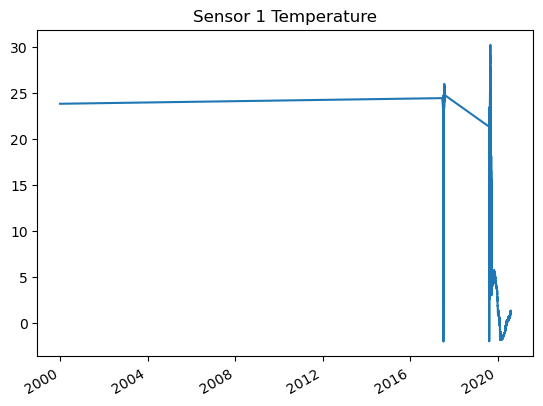

In [13]:
import pandas as pd

# Define your Steinhart-Hart coefficients for the instrument
# Replace these with your actual coefficients
COEFFICIENTS = [1.188562E-03,5.309095E-04,1.288079E-06] #12-Jul-17

# 1. Create an MTR object
# The file is parsed and converted to temperature upon creation.
mtr_data = MTR(filename='/Users/bell/ecoraid/2019/Moorings/19aubs9/raw/mtr/5011 MTR DATA.TXT', 
               version='mtrduino', 
               mtr_coef=COEFFICIENTS)

# 2. (Optional) Apply a time correction
# Let's say the clock drifted forward by 60 seconds over the deployment
mtr_data.apply_linear_drift(offset_seconds=60)

# Or, if the clock was just 5 minutes fast from the start:
# mtr_data.apply_time_offset(offset_seconds=-300)

# 3. Access your processed data
print("MTRduino Data:")
print(mtr_data.data.head())

# You can now work with the DataFrame as you normally would with pandas
mtr_data.data['s1'].plot(title='Sensor 1 Temperature')


Legacy MTR Data:
                     temperature
date_time                       
2019-09-01 00:02:00    26.337849
2019-09-01 00:02:05    26.430909
2019-09-01 00:02:10    26.483869
2019-09-01 00:02:15    26.539003
2019-09-01 00:02:20    26.608763

Legacy File Header:
STATUS
PMEL MTR revision = V4.00 December 4, 1996
MTR serial number = 4120
MTR time/date     = 88:75:07 invalid time!  00/01/2120 invalid date! (year must have 4 digits)
Start time/date   = 00:00:00 09/01/2019
Sample interval   = 00:10:00
Records logged    = 525
Extra samples     = 32
CMD> READ DATA


<Axes: title={'center': 'Legacy MTR Temperature'}, xlabel='date_time'>

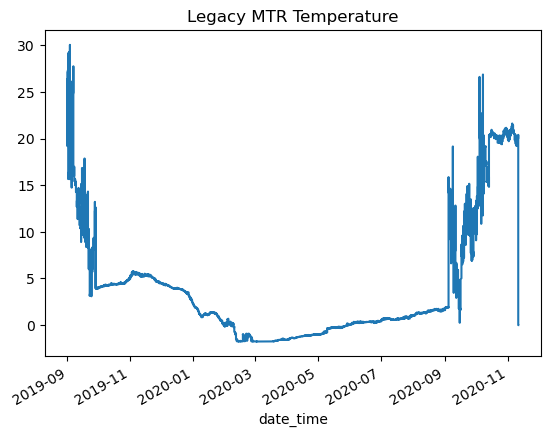

In [14]:
# Define your Steinhart-Hart coefficients
COEFFICIENTS = [1.0822588790E-03,5.3504783829E-04,2.1798086551E-06] #09-JUL-19

# 1. Create an MTR object for a legacy file
legacy_mtr = MTR(filename='/Users/bell/ecoraid/2019/Moorings/19aubs9/raw/mtr/4120 Read Data.TXT', 
                   version='legacy', 
                   mtr_coef=COEFFICIENTS)

# 2. (Optional) Apply time corrections just like before
legacy_mtr.apply_time_offset(offset_seconds=120) # Correct a 2-minute offset

# 3. Access your processed data and header
print("\nLegacy MTR Data:")
print(legacy_mtr.data.head())

print("\nLegacy File Header:")
for line in legacy_mtr.header:
    print(line)

# Plot the data
legacy_mtr.data['temperature'].plot(title='Legacy MTR Temperature')

(18262.0, 18628.0)

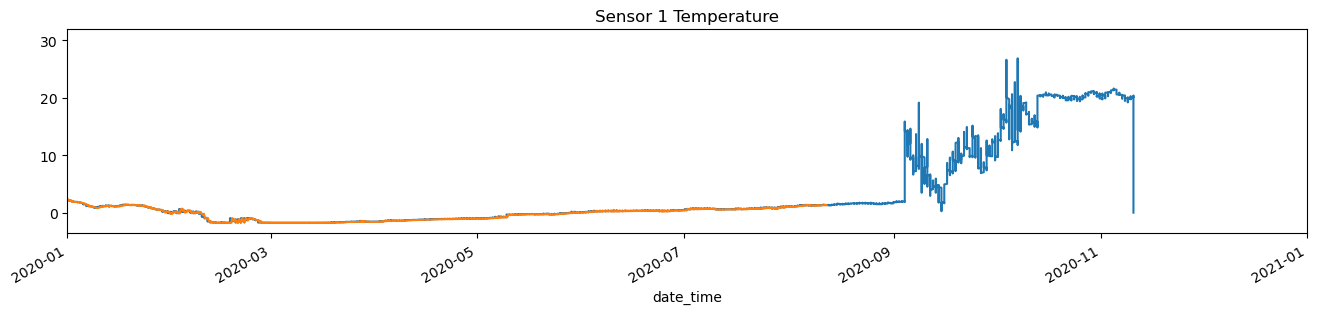

In [16]:
fig, ax = plt.subplots(1,figsize=(16, 3))
legacy_mtr.data['temperature'].plot(title='Legacy MTR Temperature',ax=ax)
mtr_data.data['s1'].plot(title='Sensor 1 Temperature',ax=ax)
ax.set_xlim(datetime.date(2020,1,1),datetime.date(2021,1,1))